# Import Libraries

In [1]:
import pandas as pd
# Import Python wrapper for or-tools CP-SAT solver.
from ortools.sat.python import cp_model
import collections
from datetime import timedelta
import datetime
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np

# Define the model

In [2]:
def MinimalJobshopSat():
    """Minimal jobshop problem."""
    # Create the model.
    model = cp_model.CpModel()

In [3]:
model = cp_model.CpModel()

# Import Data

In [5]:
imported_data_df = pd.read_excel('Toy Job Shop problem.xlsx', sheet_name='Data')

#print (imported_data_df)

#check column format
imported_data_df.dtypes

#Organisation                      object
#Task 1 completion date    datetime64[ns]
#Task 2 Completion date    datetime64[ns]
#Task 3 length                      int64
#Task 4 length                      int64
#dtype: object

#Create initialisation date 2019-10-01
imported_data_df=imported_data_df.assign(Initialisation_Date = pd.to_datetime('2019-10-01'))

#create Task_1_length column (int)
imported_data_df=imported_data_df.assign(Task_1_length = ((imported_data_df['Task 1 completion date'] - imported_data_df['Initialisation_Date'])/np.timedelta64(1,'D')).astype(int))

#creating Task_2_lenght on the assumption that task two can start only after task 1 is completed. is that the case?
imported_data_df=imported_data_df.assign(Task_2_length = ((imported_data_df['Task 2 Completion date'] - imported_data_df['Task 1 completion date'])/np.timedelta64(1,'D')).astype(int))
#df['diff_days'] = df['End_date'] - df['Start_date']
#df['diff_days']=df['diff_days']/np.timedelta64(1,'D')


#find max(Task 2 Completion date) and define Transition_Date_Start as max(Task 2 Completion date) +5
imported_data_df=imported_data_df.assign(Max_Preparation_Task_2_dt = max(imported_data_df['Task 2 Completion date']))
#imported_data_df=imported_data_df.assign(Transition_Date_Start =  imported_data_df['Max_Preparation_Task_2_dt'] + 5 )
imported_data_df["Transition_Date_Start"] = imported_data_df["Max_Preparation_Task_2_dt"] + timedelta(days=5)

#compute waiting days between task2 end date and transition start date 
wait_days = imported_data_df['Transition_Date_Start'] - imported_data_df['Task 2 Completion date']
#convert the days into integer format
Pause_length=[]
for i in wait_days:
    j = i.days
    Pause_length.append(j)
#Add this column to the dataframe 
imported_data_df['Pause_length'] = Pause_length

imported_data_df.head()

,Organisation,Task 1 completion date,Task 2 Completion date,Task 3 length,Task 4 length,Initialisation_Date,Task_1_length,Task_2_length,Max_Preparation_Task_2_dt,Transition_Date_Start,Pause_length
0,Org 1,2019-10-09,2019-10-16,15,5,2019-10-01,8,7,2019-10-20,2019-10-25,9
1,Org 2,2019-10-10,2019-10-17,15,10,2019-10-01,9,7,2019-10-20,2019-10-25,8
2,Org 3,2019-10-15,2019-10-18,15,10,2019-10-01,14,3,2019-10-20,2019-10-25,7
3,Org 4,2019-10-12,2019-10-16,20,5,2019-10-01,11,4,2019-10-20,2019-10-25,9
4,Org 5,2019-10-13,2019-10-20,25,5,2019-10-01,12,7,2019-10-20,2019-10-25,5


# Define the data

In [6]:

#task_1 = [(df.iloc[i, 0], df.iloc[i, 6]) for i in range(0,5)]
#task_1 = [([int(s) for s in t.split() if s.isdigit()][0],n) for (t,n) in task_1]
#task_2 = [(df.iloc[i, 0], df.iloc[i, 7]) for i in range(0,5)]
#task_2 = [([int(s) for s in t.split() if s.isdigit()][0],n) for (t,n) in task_2]
#task_3 = [(df.iloc[i, 0], df.iloc[i, 3]) for i in range(0,5)]
#task_3 = [([int(s) for s in t.split() if s.isdigit()][0],n) for (t,n) in task_3]
#task_4 = [(df.iloc[i, 0], df.iloc[i, 4]) for i in range(0,5)]
#task_4 = [([int(s) for s in t.split() if s.isdigit()][0],n) for (t,n) in task_4]
#task_1 = [inst(s) for s in str.split() if s.isdigit() for (s,n) in task_1]

#jobs_data = [ # task = (machine_id, processing_time).
 #           task_1, task_2, task_3, task_4
  #          ]

# jobs_data = [  # task = (machine_id, processing_time).
#         [(0, 3), (1, 2), (2, 2)],  # Job0
#         [(0, 2), (2, 1), (1, 4)],  # Job1
#         [(1, 4), (2, 3)]  # Job2
#     ]

#wait_period = 5

#df=imported_data_df
df = imported_data_df[['Organisation','Task_1_length', 'Task_2_length','Pause_length','Task 3 length','Task 4 length']]

jobs_data = []
for j in range (1, len(df.columns)):
    ls = []
    for i in range (0,len(df.index)):
        task = (i+1, df.iloc[i,j])
        ls.append(task)
    jobs_data.append(ls)
    
org_count = 1 + max(task[0] for job in jobs_data for task in job)
all_organisations = range(org_count)

In [7]:
#[print(job) for job in jobs_data]
print(jobs_data)

[[(1, 8), (2, 9), (3, 14), (4, 11), (5, 12)], [(1, 7), (2, 7), (3, 3), (4, 4), (5, 7)], [(1, 9), (2, 8), (3, 7), (4, 9), (5, 5)], [(1, 15), (2, 15), (3, 15), (4, 20), (5, 25)], [(1, 5), (2, 10), (3, 10), (4, 5), (5, 5)]]


# Define the variables

In [8]:
# Named tuple to store information about created variables.
task_type = collections.namedtuple('task_type', 'start end interval')
# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple('assigned_task_type',
                                            'start job index duration')

In [9]:
# Create job intervals and add to the corresponding machine lists.
all_tasks = {}
org_to_intervals = collections.defaultdict(list)

# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)

for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            organisation = task[0]
            duration = task[1]
            suffix = '_%i_%i' % (job_id, task_id)
            start_var = model.NewIntVar(0, int(horizon), 'start' + suffix)
            end_var = model.NewIntVar(0, int(horizon), 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                'interval' + suffix)
            all_tasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var)
            org_to_intervals[organisation].append(interval_var)

# Define the constraints

In [10]:
# Create and add disjunctive constraints.
for organisation in all_organisations:
    model.AddNoOverlap(org_to_intervals[organisation])
    
# Precedences inside a job.
#for job_id, job in enumerate(jobs_data):
#    for task_id in range(len(job) - 1):
#        model.Add(all_tasks[job_id, task_id +
#                            1].start >= all_tasks[job_id, task_id].end)

# Define the objective

In [11]:
# Makespan objective.
obj_var = model.NewIntVar(0, int(horizon), 'makespan')
model.AddMaxEquality(obj_var, [
    all_tasks[job_id, len(job) - 1].end
    for job_id, job in enumerate(jobs_data)
])
model.Minimize(obj_var)

# Declare the solver

In [12]:
# Solve model.
solver = cp_model.CpSolver()
status = solver.Solve(model)

# Display the results

In [13]:
# Create one list of assigned tasks per machine.
assigned_jobs = collections.defaultdict(list)
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        organisation = task[0]
        assigned_jobs[organisation].append(
            assigned_task_type(
                start=solver.Value(all_tasks[job_id, task_id].start),
                job=job_id,
                index=task_id,
                duration=task[1]))

# Create per organisation output lines.
output = ''
for organisation in all_organisations:
    # Sort by starting time.
    assigned_jobs[organisation].sort()
    sol_line_tasks = 'Organisation ' + str(organisation) + ': '
    sol_line = '           '

    for assigned_task in assigned_jobs[organisation]:
        name = 'job_%i_%i' % (assigned_task.job, assigned_task.index)
        # Add spaces to output to align columns.
        sol_line_tasks += '%-10s' % name

        start = assigned_task.start
        duration = assigned_task.duration
        sol_tmp = '[%i,%i]' % (start, start + duration)
        # Add spaces to output to align columns.
        sol_line += '%-10s' % sol_tmp

    sol_line += '\n'
    sol_line_tasks += '\n'
    output += sol_line_tasks
    output += sol_line

# Finally print the solution found.
print('Optimal Schedule Length: %i' % solver.ObjectiveValue())
print(output)

Optimal Schedule Length: 54
Organisation 0: 
           
Organisation 1: job_0_0   job_1_0   job_2_0   job_3_0   job_4_0   
           [0,8]     [8,15]    [15,24]   [24,39]   [39,44]   
Organisation 2: job_0_1   job_1_1   job_2_1   job_3_1   job_4_1   
           [0,9]     [9,16]    [16,24]   [24,39]   [39,49]   
Organisation 3: job_0_2   job_1_2   job_2_2   job_3_2   job_4_2   
           [0,14]    [14,17]   [17,24]   [24,39]   [39,49]   
Organisation 4: job_0_3   job_1_3   job_2_3   job_3_3   job_4_3   
           [0,11]    [11,15]   [15,24]   [24,44]   [44,49]   
Organisation 5: job_0_4   job_1_4   job_2_4   job_3_4   job_4_4   
           [0,12]    [12,19]   [19,24]   [24,49]   [49,54]   



# Visualize the results

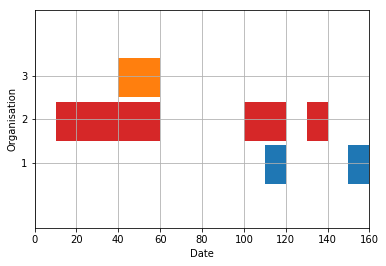

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# Declaring a figure "gnt" 
fig, gnt = plt.subplots() 

# Setting Y-axis limits 
gnt.set_ylim(0, 50) 

# Setting X-axis limits 
gnt.set_xlim(0, 160) 

# Setting labels for x-axis and y-axis 
gnt.set_xlabel('Date') 
gnt.set_ylabel('Organisation') 

# Setting ticks on y-axis 
gnt.set_yticks([15, 25, 35]) 
# Labelling tickes of y-axis 
gnt.set_yticklabels(['1', '2', '3']) 

# Setting graph attribute 
gnt.grid(True) 

# Declaring a bar in schedule 
gnt.broken_barh([(40, 20)], (30, 9),
facecolors =('tab:orange')) 

# Declaring multiple bars in at same level and same width 
gnt.broken_barh([(110, 10), (150, 10)], (10, 9),
facecolors ='tab:blue') 

gnt.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9),
facecolors =('tab:red')) 

#plt.savefig("gantt1.png") 


# Complete Code (Modularization)

In [20]:
import pandas as pd
# Import Python wrapper for or-tools CP-SAT solver.
from ortools.sat.python import cp_model
import collections
from datetime import timedelta
import datetime
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np

def MinimalJobshopToy():
    #define the model
    model = cp_model.CpModel()
    
    '''Import Data'''
    #set data directory
    data_dir='Toy Job Shop problem.xlsx'
    
    imported_data_df = pd.read_excel(data_dir, sheet_name='Data')

    #print (imported_data_df)

    #check column format
    imported_data_df.dtypes

    #Organisation                      object
    #Task 1 completion date    datetime64[ns]
    #Task 2 Completion date    datetime64[ns]
    #Task 3 length                      int64
    #Task 4 length                      int64
    #dtype: object

    #Create initialisation date 2019-10-01
    imported_data_df=imported_data_df.assign(Initialisation_Date = pd.to_datetime('2019-10-01'))

    #create Task_1_length column (int)
    imported_data_df=imported_data_df.assign(Task_1_length = ((imported_data_df['Task 1 completion date'] - imported_data_df['Initialisation_Date'])/np.timedelta64(1,'D')).astype(int))

    #creating Task_2_lenght on the assumption that task two can start only after task 1 is completed. is that the case?
    imported_data_df=imported_data_df.assign(Task_2_length = ((imported_data_df['Task 2 Completion date'] - imported_data_df['Task 1 completion date'])/np.timedelta64(1,'D')).astype(int))
    #df['diff_days'] = df['End_date'] - df['Start_date']
    #df['diff_days']=df['diff_days']/np.timedelta64(1,'D')


    #find max(Task 2 Completion date) and define Transition_Date_Start as max(Task 2 Completion date) +5
    imported_data_df=imported_data_df.assign(Max_Preparation_Task_2_dt = max(imported_data_df['Task 2 Completion date']))
    #imported_data_df=imported_data_df.assign(Transition_Date_Start =  imported_data_df['Max_Preparation_Task_2_dt'] + 5 )
    imported_data_df["Transition_Date_Start"] = imported_data_df["Max_Preparation_Task_2_dt"] + timedelta(days=5)
    
    #compute waiting days between task2 end date and transition start date 
    wait_days = imported_data_df['Transition_Date_Start'] - imported_data_df['Task 2 Completion date']
    #convert the days into integer format
    Pause_length=[]
    for i in wait_days:
        j = i.days
        Pause_length.append(j)
    #Add this column to the dataframe 
    imported_data_df['Pause_length'] = Pause_length
    

    
    '''Define the data'''
    df = imported_data_df[['Organisation','Task_1_length', 'Task_2_length','Pause_length','Task 3 length','Task 4 length']]
    
    jobs_data = []
    for j in range (1, len(df.columns)):
        ls = []
        for i in range (0,len(df.index)):
            task = (i+1, df.iloc[i,j])
            ls.append(task)
        jobs_data.append(ls)
    
    org_count = 1 + max(task[0] for job in jobs_data for task in job)
    all_organisations = range(org_count)
    
    
    '''Define Variables'''
    # Named tuple to store information about created variables.
    task_type = collections.namedtuple('task_type', 'start end interval')
    # Named tuple to manipulate solution information.
    assigned_task_type = collections.namedtuple('assigned_task_type',
                                                'start job index duration')
    
    # Create job intervals and add to the corresponding machine lists.
    all_tasks = {}
    org_to_intervals = collections.defaultdict(list)

    # Computes horizon dynamically as the sum of all durations.
    horizon = sum(task[1] for job in jobs_data for task in job)

    for job_id, job in enumerate(jobs_data):
            for task_id, task in enumerate(job):
                organisation = task[0]
                duration = task[1]
                suffix = '_%i_%i' % (job_id, task_id)
                start_var = model.NewIntVar(0, int(horizon), 'start' + suffix)
                end_var = model.NewIntVar(0, int(horizon), 'end' + suffix)
                interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                    'interval' + suffix)
                all_tasks[job_id, task_id] = task_type(
                    start=start_var, end=end_var, interval=interval_var)
                org_to_intervals[organisation].append(interval_var)
    
    
    '''Define Constraints'''
    # Create and add disjunctive constraints.
    for organisation in all_organisations:
        model.AddNoOverlap(org_to_intervals[organisation])

    
    '''Define the Objective'''
    # Makespan objective.
    obj_var = model.NewIntVar(0, int(horizon), 'makespan')
    model.AddMaxEquality(obj_var, [
        all_tasks[job_id, len(job) - 1].end
        for job_id, job in enumerate(jobs_data)
    ])
    model.Minimize(obj_var)
    
    
    '''Declare the Solver'''
    # Solve model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    
    '''Display the results'''
    # Create one list of assigned tasks per machine.
    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            organisation = task[0]
            assigned_jobs[organisation].append(
                assigned_task_type(
                    start=solver.Value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task[1]))

    # Create per organisation output lines.
    output = ''
    for organisation in all_organisations:
        # Sort by starting time.
        assigned_jobs[organisation].sort()
        sol_line_tasks = 'Organisation ' + str(organisation) + ': '
        sol_line = '           '

        for assigned_task in assigned_jobs[organisation]:
            name = 'job_%i_%i' % (assigned_task.job, assigned_task.index)
            # Add spaces to output to align columns.
            sol_line_tasks += '%-10s' % name

            start = assigned_task.start
            duration = assigned_task.duration
            sol_tmp = '[%i,%i]' % (start, start + duration)
            # Add spaces to output to align columns.
            sol_line += '%-10s' % sol_tmp

        sol_line += '\n'
        sol_line_tasks += '\n'
        output += sol_line_tasks
        output += sol_line

    # Finally print the solution found.
    print('Optimal Schedule Length: %i' % solver.ObjectiveValue())
    print(output)


In [21]:
MinimalJobshopToy()

Optimal Schedule Length: 54
Organisation 0: 
           
Organisation 1: job_0_0   job_1_0   job_2_0   job_3_0   job_4_0   
           [0,8]     [8,15]    [15,24]   [24,39]   [39,44]   
Organisation 2: job_0_1   job_1_1   job_2_1   job_3_1   job_4_1   
           [0,9]     [9,16]    [16,24]   [24,39]   [39,49]   
Organisation 3: job_0_2   job_1_2   job_2_2   job_3_2   job_4_2   
           [0,14]    [14,17]   [17,24]   [24,39]   [39,49]   
Organisation 4: job_0_3   job_1_3   job_2_3   job_3_3   job_4_3   
           [0,11]    [11,15]   [15,24]   [24,44]   [44,49]   
Organisation 5: job_0_4   job_1_4   job_2_4   job_3_4   job_4_4   
           [0,12]    [12,19]   [19,24]   [24,49]   [49,54]   



In [22]:
## TODO: 

# Convert the outputs from the solver into dates
# Get the visualisation working. (Build out two visulations one for high level and one for lower level tasks).
# General tidy up of the code (make more generalisable as we go forward)
# Organisation numbers not lined up exactly?